In [1]:
import cobra
import pandas as pd
import numpy as np
from scipy.optimize import linprog
from scipy.stats import ttest_ind

from cobra.flux_analysis import flux_variability_analysis
from cobra.sampling import sample

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
expression_data = pd.read_csv(
    "/Users/karthik/Desktop/PHCCO IISc Internship/cancer_cell_expression_data.csv"
)
expression_data.head()

,Gene_ID,Sensitive,Resistant
0,126792_AT1,22.453333,21.780000
1,65220_AT1,23.783333,26.776667
2,9651_AT1,0.430700,0.333167
3,55229_AT1,8.613000,6.816000
4,11332_AT1,67.123333,40.183333


In [55]:
# Extract the list of genes from the expression data
expression_genes = expression_data["Gene_ID"].tolist()

from cobra.manipulation.delete import remove_genes


def filter_model_by_genes(model, genes):
    """
    Filter a COBRA model to include only reactions associated with a given list of genes.
    """
    # Copy the model
    new_model = model.copy()

    # Get the list of genes in the model
    genes_in_model = [gene.id for gene in new_model.genes]

    # Find genes to remove
    genes_to_remove = list(set(genes_in_model) - set(genes))

    # Remove genes and their associated reactions
    remove_genes(new_model, genes_to_remove, remove_reactions=True)

    return new_model


# Create the context-specific model
filtered_model = filter_model_by_genes(recon3d_model, expression_genes)

# Save or analyze the new model
cobra.io.write_sbml_model(filtered_model, "FilteredRecon3DModel.xml")

In [3]:
new_model = cobra.io.read_sbml_model("FilteredRecon3DModel.xml")
new_model

Name,Recon3D
Memory address,10a3881d0
Number of metabolites,5835
Number of reactions,9957
Number of genes,1597
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, lysosome, mitochondria, endoplasmic reticulum, extracellular space, peroxisome/glyoxysome, nucleus, golgi apparatus, inner mitochondrial compartment"


In [4]:
import numpy as np


def get_reaction_expression_array(model, expression_data):
    expressionRxn = [0.0] * len(model.reactions)
    for idx, reaction in enumerate(model.reactions):
        for gene in reaction.genes:
            if gene.id in expression_data["Gene_ID"].values:
                gene_row = expression_data[expression_data["Gene_ID"] == gene.id].iloc[
                    0
                ]
                expression_score = gene_row["Sensitive"]
                expressionRxn[idx] = expression_score

    return np.array(expressionRxn)


reaction_expression_array = get_reaction_expression_array(new_model, expression_data)

reaction_expression_array

array([0., 0., 0., ..., 0., 0., 0.])

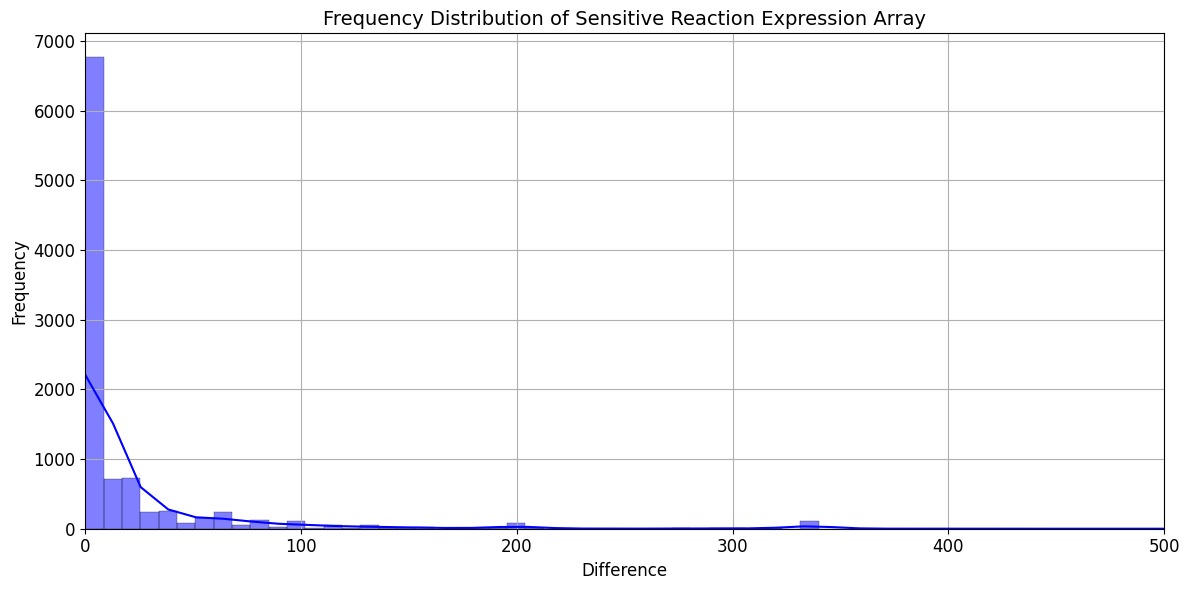

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a histogram of differences
plt.figure(figsize=(12, 6))
sns.histplot(reaction_expression_array, bins=300, kde=True, color="blue")

# Adjust font sizes
plt.xlabel("Difference", fontsize=12)  # Set x-axis label font size
plt.ylabel("Frequency", fontsize=12)  # Set y-axis label font size
plt.title(
    "Frequency Distribution of Sensitive Reaction Expression Array", fontsize=14
)  # Set plot title font size

# Set tick labels font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Limit x-axis range
plt.xlim(0, 500)  # Adjust the limits according to your data range

plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
import numpy as np
from cobra.flux_analysis import flux_variability_analysis


def iMAT(model, expressionRxns, tol=1e-8, core=None):
    """
    Uses the iMAT algorithm to extract a context-specific model using data.

    Parameters:
    model : cobra.Model
        Input COBRA model.
    expressionRxns : np.ndarray
        Reaction expression data corresponding to model.reactions.
        Use -1 if no gene-expression data are available for a reaction.
    tol : float, optional
        Minimum flux threshold for "expressed" reactions (default is 1e-8).
    core : list of str, optional
        List of reaction IDs to manually include in the high-confidence set (default is None).

    Returns:
    cobra.Model
        Extracted tissue-specific model.
    """

    # Thresholding based on expression data
    mean_expression = np.mean(expressionRxns)
    std_expression = np.std(expressionRxns)

    threshold_lb = mean_expression - std_expression
    threshold_ub = mean_expression + std_expression

    RHindex = np.where(expressionRxns >= threshold_ub)[0]
    RLindex = np.where((expressionRxns >= 0) & (expressionRxns < threshold_lb))[0]

    # Manually add core reactions to the high-confidence set
    if core:
        RHindex = np.union1d(
            RHindex, [model.reactions.index(r) for r in core if r in model.reactions]
        )

    # Perform flux variability analysis (FVA) to get reaction bounds
    fva_result = flux_variability_analysis(model, fraction_of_optimum=1e-6)

    # Identify reactions to keep based on iMAT criteria
    rxns_to_keep = []
    for i, reaction in enumerate(model.reactions):

        if i in RHindex and fva_result["maximum"][i] > tol:
            rxns_to_keep.append(reaction.id)

        elif i in RLindex and fva_result["minimum"][i] < -tol:
            rxns_to_keep.append(reaction.id)

    model_rxn_ids = set()
    for rxn in model.reactions:
        model_rxn_ids.add(rxn.id)

    removed_reaction_ids = set()

    for rxn_id in rxns_to_keep:
        if rxn_id not in model_rxn_ids:
            removed_reaction_ids.add(rxn_id)

    print(f"Total num of removed reactions: {len(removed_reaction_ids)}")

    # Create a new model with only the reactions to keep
    tissue_model = model.copy()

    genes_to_remove = set()
    for rxn_id in removed_reaction_ids:
        for gene in model.reactions.get_by_id(rxn_id).genes:
            genes_to_remove.add(gene.id)

    genes_to_remove = list(genes_to_remove)
    remove_genes(tissue_model, genes_to_remove, remove_reactions=True)

    return tissue_model, fva_result


tissue_csm, fva_result = iMAT(new_model, reaction_expression_array)
tissue_csm

/var/folders/6x/c19tq81j2954h_g4n73r3lp40000gn/T/ipykernel_17617/821984929.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if i in RHindex and fva_result["maximum"][i] > tol:


Total num of removed reactions: 9957


Name,Recon3D
Memory address,31bb60590
Number of metabolites,5835
Number of reactions,9957
Number of genes,1597
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, lysosome, mitochondria, endoplasmic reticulum, extracellular space, peroxisome/glyoxysome, nucleus, golgi apparatus, inner mitochondrial compartment"


In [4]:
def create_context_specific_model(
    model,
    expression_data,
    genes_column_name="Gene_ID",
    expression_values_column_name="Sensitive",
):

    # NOTE: Assumed that the gene_column contains Gene IDS

    # Step 1: Map expression data to model genes
    gene_ids = expression_data[genes_column_name].tolist()
    model_genes = [gene.id for gene in model.genes]

    # Filter model genes based on intersection with expression data
    genes_to_keep = set(gene_ids).intersection(set(model_genes))

    # Generate reaction expression array
    reaction_expression_array = [0.0] * len(model.reactions)
    for idx, reaction in enumerate(model.reactions):
        for gene in reaction.genes:
            if gene.id in expression_data["Gene_ID"].values:
                gene_row = expression_data[expression_data["Gene_ID"] == gene.id].iloc[
                    0
                ]
                expression_score = gene_row["Sensitive"]
                reaction_expression_array[idx] = expression_score
    reaction_expression_array = np.array(reaction_expression_array)

    # Thresholding based on expression data
    mean_expression = np.mean(reaction_expression_array)
    std_expression = np.std(reaction_expression_array)

    threshold_lb = mean_expression - std_expression
    threshold_ub = mean_expression + std_expression

    # Step 2: Classify genes based on expression thresholds
    highly_expressed_genes = expression_data[
        expression_data[expression_values_column_name] >= threshold_ub
    ][genes_column_name].tolist()
    lowly_expressed_genes = expression_data[
        expression_data[expression_values_column_name] < threshold_lb
    ][genes_column_name].tolist()

    # Step 3: Perform FVA and adjust model reactions
    fva_result = flux_variability_analysis(model, fraction_of_optimum=0.95)

    for reaction in model.reactions:
        reaction_id = reaction.id
        associated_genes = [gene.id for gene in reaction.genes]

        # Check if reaction has associated genes in the expression data
        if any(gene_id in genes_to_keep for gene_id in associated_genes):
            
            # Adjust bounds based on expression level
            if any(gene_id in highly_expressed_genes for gene_id in associated_genes):
                min_flux = fva_result.loc[reaction_id, "minimum"]
                max_flux = fva_result.loc[reaction_id, "maximum"]
            
                if min_flux <= max_flux:
                    reaction.bounds = (min_flux, max_flux)
                else:
                    print(f"Warning: Invalid bounds for reaction {reaction_id}. Skipping...")
                    continue
            
            elif any(gene_id in lowly_expressed_genes for gene_id in associated_genes):
                    reaction.bounds = (0.0, 0.0)
        else:
            # No associated genes, deactivate reaction
            reaction.bounds = (0.0, 0.0)

    return model


sensitive_csm = create_context_specific_model(
    model=new_model,
    expression_data=expression_data,
    genes_column_name="Gene_ID",
    expression_values_column_name="Sensitive",
)

In [13]:
def validate_and_adjust_reactions(model):
    """
    Validate and adjust reaction properties to ensure compatibility with SBML export.
    """
    for reaction in model.reactions:
        lower_bound = reaction.lower_bound
        upper_bound = reaction.upper_bound
        
        # Ensure bounds are numeric and valid
        if lower_bound is None or upper_bound is None:
            print(f"Skipping reaction {reaction.id} due to invalid bounds.")
            continue
        
        # Ensure lower bound is less than or equal to upper bound
        if lower_bound > upper_bound:
            print(f"Adjusting bounds for reaction {reaction.id} as lower bound > upper bound.")
            reaction.lower_bound = min(lower_bound, upper_bound)
            reaction.upper_bound = max(lower_bound, upper_bound)
        
        # Explicitly set reversible property based on adjusted bounds
        reaction.reversible = bool(reaction.lower_bound < 0)
        
        print(f"reversibility: {reaction.reversible}")
        
# Validate and adjust reactions before exporting
validate_and_adjust_reactions(sensitive_csm)

reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: True
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: True
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: False
reversibility: True
reversibility: False
reversibility: False
reversibility: F

In [14]:
# Save the context-specific model to an SBML file
cobra.io.write_sbml_model(sensitive_csm, "sensitive_csm.xml")

TypeError: in method 'Reaction_setReversible', argument 2 of type 'bool'

In [5]:
fva_result.head()

NameError: name 'fva_result' is not defined

In [8]:
#fva_result.to_csv("sensitive_fva.csv", index=False)
cobra.io.write_sbml_model(sensitive_csm, "sensitive_csm.xml")

TypeError: in method 'Reaction_setReversible', argument 2 of type 'bool'

In [12]:
sensitive_model = cobra.io.read_sbml_model("sensitive_csm.xml")
resistant_model = cobra.io.read_sbml_model("resistant_csm.xml")

In [13]:
# Define a function to compare flux distributions
def compare_flux_differences(model_original, model_tissue_specific, condition=None):
    # Set the condition or objective function for flux calculation
    if condition:
        model_original.objective = condition
        model_tissue_specific.objective = condition

    # Optimize both models to calculate flux distributions
    solution_original = model_original.optimize()
    solution_tissue_specific = model_tissue_specific.optimize()

    # Extract flux distributions
    fluxes_original = solution_original.fluxes
    fluxes_tissue_specific = solution_tissue_specific.fluxes

    # Create a DataFrame to compare fluxes
    flux_comparison = pd.DataFrame(
        {
            "Reaction": fluxes_original.index,
            "Sensitive": fluxes_original.values,
            "Resistant": fluxes_tissue_specific.values,
            "Difference": fluxes_original.values - fluxes_tissue_specific.values,
        }
    )

    return flux_comparison


# objective_condition = lung_cancer_model.reactions.get_by_id('ATPM')

# Verify flux differences other than zero
flux_differences_df = compare_flux_differences(sensitive_model, resistant_model)

# Filter out rows where the Original Flux is equal to the Tissue-specific Flux
filtered_flux_differences = flux_differences_df[
    flux_differences_df["Sensitive"] != flux_differences_df["Resistant"]
]

filtered_flux_differences.head()

,Reaction,Sensitive,Resistant,Difference
